## Delta Lake版

### テストデータの用意

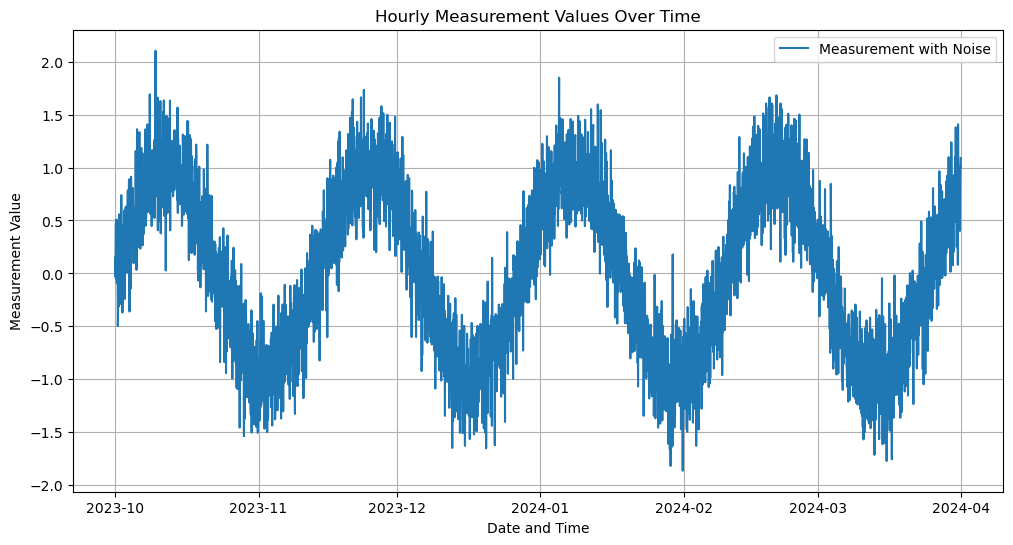

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 乱数のシード設定
np.random.seed(42)

# サンプル時系列データの生成 (1時間毎データ)
h_range = pd.date_range(start="2023-10-01", end="2024-03-31 23:00:00", freq="H")
hours = np.arange(len(h_range))

# サンプルデータを生成 (週周期で時間単位のsin波)
sin_wave = np.sin(hours / (7 * 24))
# ランダムノイズを生成
noise = np.random.normal(0, 0.3, len(h_range))
# 波形にランダムノイズを付与
measurement_values = sin_wave + noise

# 描画
plt.figure(figsize=(12, 6))
plt.plot(h_range, measurement_values, label='Measurement with Noise')
plt.title('Hourly Measurement Values Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Measurement Value')
plt.legend()
plt.grid(True)
plt.show()

### 必要モジュールのインストール

In [2]:
!pip install delta-spark

### Sparkで月単位のデータとして保存する

In [3]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql.functions import dayofmonth, month, year

# Sparkセッションの初期化
builder = (
    SparkSession.builder.appName("partition_example")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
# Delta Lakeで動作するように設定
spark = configure_spark_with_delta_pip(builder).getOrCreate()

# pandasのDataFrameを作成
pandas_df = pd.DataFrame({
    "datetime": h_range,
    "measurement": measurement_values
}    
)
# Spark DataFrameに変換
df = spark.createDataFrame(pandas_df)
# 年・月・日の列を作成しておく
df = df.withColumn("year", year("datetime"))
df = df.withColumn("month", month("datetime"))
df = df.withColumn("day", dayofmonth("datetime"))
df.show()

# 年単位でパーティション分割して保存
df.write.format("delta").mode("overwrite").partitionBy("year").save("./yearly-delta")

# 月単位でパーティション分割して保存
df.write.format("delta").mode("overwrite").partitionBy("year", "month").save("./monthly-delta")

# 日単位でパーティション分割して保存
df.write.format("delta").mode("overwrite").partitionBy("year", "month", "day").save("./daily-delta")

+-------------------+--------------------+----+-----+---+
|           datetime|         measurement|year|month|day|
+-------------------+--------------------+----+-----+---+
|2023-10-01 00:00:00| 0.14901424590336979|2023|   10|  1|
|2023-10-01 01:00:00|-0.03552694454855405|2023|   10|  1|
|2023-10-01 02:00:00| 0.20621104213982733|2023|   10|  1|
|2023-10-01 03:00:00|  0.4747651507543513|2023|   10|  1|
|2023-10-01 04:00:00|-0.04643873812079383|2023|   10|  1|
|2023-10-01 05:00:00|-0.04048357583349...|2023|   10|  1|
|2023-10-01 06:00:00|  0.5094705385280494|2023|   10|  1|
|2023-10-01 07:00:00|  0.2718850301318917|2023|   10|  1|
|2023-10-01 08:00:00| -0.0932412627377515|2023|   10|  1|
|2023-10-01 09:00:00| 0.21631382123497145|2023|   10|  1|
|2023-10-01 10:00:00|-0.07953664173541525|2023|   10|  1|
|2023-10-01 11:00:00|-0.07428950974074038|2023|   10|  1|
|2023-10-01 12:00:00| 0.14395652980988882|2023|   10|  1|
|2023-10-01 13:00:00| -0.4966803216627974|2023|   10|  1|
|2023-10-01 14

### データを読み込む

In [4]:
# 特定フォルダを指定して読み込む場合
df_read = spark.read.format("delta").load("./monthly-delta/year=2023/month=10")

# ソートしてから表示
df_read = df_read.sort(df_read.datetime)
df_read.show(5)
df_read.orderBy(df_read.datetime, ascending=False).show(5)

+-------------------+--------------------+----+-----+---+
|           datetime|         measurement|year|month|day|
+-------------------+--------------------+----+-----+---+
|2023-10-01 00:00:00| 0.14901424590336979|2023|   10|  1|
|2023-10-01 01:00:00|-0.03552694454855405|2023|   10|  1|
|2023-10-01 02:00:00| 0.20621104213982733|2023|   10|  1|
|2023-10-01 03:00:00|  0.4747651507543513|2023|   10|  1|
|2023-10-01 04:00:00|-0.04643873812079383|2023|   10|  1|
+-------------------+--------------------+----+-----+---+
only showing top 5 rows

+-------------------+-------------------+----+-----+---+
|           datetime|        measurement|year|month|day|
+-------------------+-------------------+----+-----+---+
|2023-10-31 23:00:00|-0.9504823233260842|2023|   10| 31|
|2023-10-31 22:00:00|-1.1440374606662784|2023|   10| 31|
|2023-10-31 21:00:00|-1.3387133335934447|2023|   10| 31|
|2023-10-31 20:00:00|-1.5053170384963321|2023|   10| 31|
|2023-10-31 19:00:00|  -0.64692450768512|2023|   10| 3

In [5]:
# フォルダ配下をまとめて読み込む場合
df_read = spark.read.format("delta").load("./monthly-delta/year=2023")

# ソートしてから表示
df_read = df_read.sort(df_read.datetime)
df_read.show(5)
df_read.orderBy(df_read.datetime, ascending=False).show(5)

+-------------------+--------------------+----+-----+---+
|           datetime|         measurement|year|month|day|
+-------------------+--------------------+----+-----+---+
|2023-10-01 00:00:00| 0.14901424590336979|2023|   10|  1|
|2023-10-01 01:00:00|-0.03552694454855405|2023|   10|  1|
|2023-10-01 02:00:00| 0.20621104213982733|2023|   10|  1|
|2023-10-01 03:00:00|  0.4747651507543513|2023|   10|  1|
|2023-10-01 04:00:00|-0.04643873812079383|2023|   10|  1|
+-------------------+--------------------+----+-----+---+
only showing top 5 rows

+-------------------+-------------------+----+-----+---+
|           datetime|        measurement|year|month|day|
+-------------------+-------------------+----+-----+---+
|2023-12-31 23:00:00| 0.6467656757056162|2023|   12| 31|
|2023-12-31 22:00:00| 0.9802973425873306|2023|   12| 31|
|2023-12-31 21:00:00| 0.6717463226887521|2023|   12| 31|
|2023-12-31 20:00:00|0.23803665242220395|2023|   12| 31|
|2023-12-31 19:00:00| 0.1319102042628495|2023|   12| 3

In [6]:
# いくつかのフォルダを複数読み込む場合
df1 = spark.read.format("delta").load("./monthly-delta/year=2023/month=11")
df2 = spark.read.format("delta").load("./monthly-delta/year=2023/month=12")
df_read = df1.union(df2)

# ソートしてから表示
df_read = df_read.sort(df_read.datetime)
df_read.show(5)
df_read.orderBy(df_read.datetime, ascending=False).show(5)

+-------------------+-------------------+----+-----+---+
|           datetime|        measurement|year|month|day|
+-------------------+-------------------+----+-----+---+
|2023-11-01 00:00:00|-0.8046957296660957|2023|   11|  1|
|2023-11-01 01:00:00|-1.1793663638979297|2023|   11|  1|
|2023-11-01 02:00:00|-0.9072289030283197|2023|   11|  1|
|2023-11-01 03:00:00| -1.191455395525611|2023|   11|  1|
|2023-11-01 04:00:00| -1.149843255157325|2023|   11|  1|
+-------------------+-------------------+----+-----+---+
only showing top 5 rows

+-------------------+-------------------+----+-----+---+
|           datetime|        measurement|year|month|day|
+-------------------+-------------------+----+-----+---+
|2023-12-31 23:00:00| 0.6467656757056162|2023|   12| 31|
|2023-12-31 22:00:00| 0.9802973425873306|2023|   12| 31|
|2023-12-31 21:00:00| 0.6717463226887521|2023|   12| 31|
|2023-12-31 20:00:00|0.23803665242220395|2023|   12| 31|
|2023-12-31 19:00:00| 0.1319102042628495|2023|   12| 31|
+-----

In [7]:
# SparkSessionを終了
spark.stop()